# Kategorická klasifikace pomocí neuronových sítí

Nejprve naimportujeme potřebné knihovny a nastavíme konstanty pro trénování.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}")

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

cuda


## Dataset

Načteme data ze souboru train.csv a rozdělíme je na trénovací, validační a testovací množiny.


In [62]:
train_df = pd.read_csv("train.csv")
print("Rozměry trénovacích dat:", train_df.shape)
train_df.head()

Rozměry trénovacích dat: (52500, 1025)


,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,0
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [63]:
X = train_df.drop("label", axis=1).values
y = train_df["label"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.4, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=SEED
)

print(f"Velikost trénovací sady: {X_train.shape[0]} vzorků")
print(f"Velikost validační sady: {X_val.shape[0]} vzorků")
print(f"Velikost testovací sady: {X_test.shape[0]} vzorků")

IMG_SIZE = 32
X_train_img = X_train.reshape(-1, 1, IMG_SIZE, IMG_SIZE).astype(np.float32)
X_val_img = X_val.reshape(-1, 1, IMG_SIZE, IMG_SIZE).astype(np.float32)
X_test_img = X_test.reshape(-1, 1, IMG_SIZE, IMG_SIZE).astype(np.float32)

# FNN
X_train_flat = X_train.astype(np.float32)
X_val_flat = X_val.astype(np.float32)
X_test_flat = X_test.astype(np.float32)

# LongTensor pro CrossEntropyLoss
y_train_tensor = torch.from_numpy(y_train).long()
y_val_tensor = torch.from_numpy(y_val).long()
y_test_tensor = torch.from_numpy(y_test).long()

Velikost trénovací sady: 31500 vzorků
Velikost validační sady: 10500 vzorků
Velikost testovací sady: 10500 vzorků


## Průzkum dat (EDA)

Provedeme základní průzkum dat.


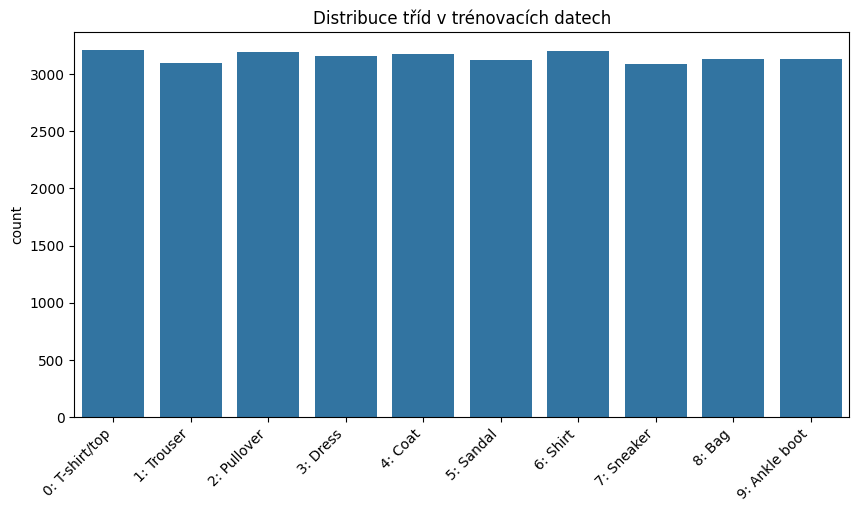

Distribuce tříd v trénovacích datech:
 0    3206
1    3097
2    3194
3    3157
4    3178
5    3123
6    3200
7    3088
8    3129
9    3128
Name: count, dtype: int64


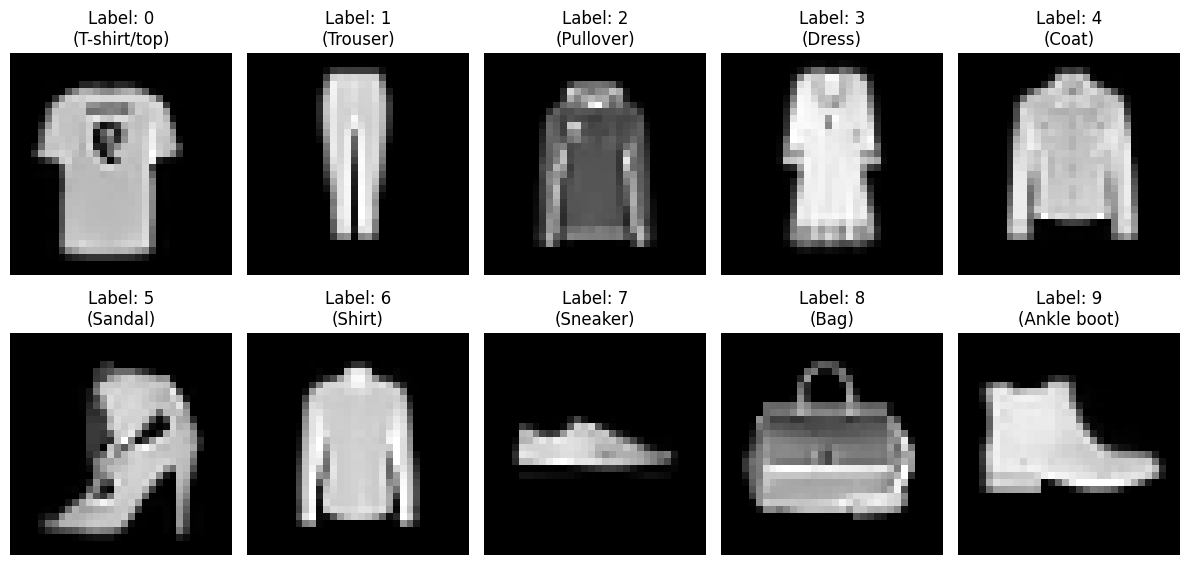

Minimální hodnota pixelu: 0
Maximální hodnota pixelu: 255


In [64]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title("Distribuce tříd v trénovacích datech")
plt.xticks(
    ticks=range(10),
    labels=[f"{i}: {class_names[i]}" for i in range(10)],
    rotation=45,
    ha="right",
)
plt.show()
print(
    "Distribuce tříd v trénovacích datech:\n",
    pd.Series(y_train).value_counts().sort_index(),
)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(X_train_img[idx, 0], cmap="gray")
    axes[i].set_title(f"Label: {i}\n({class_names[i]})")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

print(f"Minimální hodnota pixelu: {X_train.min()}")
print(f"Maximální hodnota pixelu: {X_train.max()}")

## Normalizace/Standardizace dat

Neuronové sítě obecně lépe fungují s normalizovanými daty. Vyzkoušíme dvě strategie:
Normalizace na [0, 1]: Dělení hodnot pixelů číslem 255.0.
Standardizace: Odečtení průměru a dělení směrodatnou odchylkou (počítáno z trénovacích dat).


In [65]:
X_train_norm = X_train_flat / 255.0
X_val_norm = X_val_flat / 255.0
X_test_norm = X_test_flat / 255.0

X_train_img_norm = X_train_img / 255.0
X_val_img_norm = X_val_img / 255.0
X_test_img_norm = X_test_img / 255.0

scaler_flat = StandardScaler()
X_train_std = scaler_flat.fit_transform(X_train_flat)
X_val_std = scaler_flat.transform(X_val_flat)

mean_img = X_train_img.mean()
std_img = X_train_img.std()

X_train_img_std = (X_train_img - mean_img) / std_img
X_val_img_std = (X_val_img - mean_img) / std_img

print("Tvary normalizovaných dat pro FNN:", X_train_norm.shape)
print("Tvary standardizovaných dat pro FNN:", X_train_std.shape)
print("Tvary normalizovaných dat pro CNN:", X_train_img_norm.shape)
print("Tvary standardizovaných dat pro CNN:", X_train_img_std.shape)
print(
    f"Průměr pro standardizaci obrázků: {mean_img:.4f}, Směrodatná odchylka: {std_img:.4f}"
)

Tvary normalizovaných dat pro FNN: (31500, 1024)
Tvary standardizovaných dat pro FNN: (31500, 1024)
Tvary normalizovaných dat pro CNN: (31500, 1, 32, 32)
Tvary standardizovaných dat pro CNN: (31500, 1, 32, 32)
Průměr pro standardizaci obrázků: 44.8483, Směrodatná odchylka: 75.5722


In [66]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=20,
    model_name="Model",
):
    """Trénuje a evaluuje model."""
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    best_model_state = None

    print(f"Trénování modelu: {model_name}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validace
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(
            f"Epoch {epoch+1}/{num_epochs} - "
            f"Train Loss: {epoch_loss:.4f}, "
            f"Val Loss: {epoch_val_loss:.4f}, "
            f"Val Acc: {epoch_val_acc:.4f}"
        )

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}

    print(f"Nejlepší validační přesnost pro {model_name}: {best_val_acc:.4f}")

    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Loss: {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.title(f"Accuracy: {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return model, best_val_acc

## Dopředné neuronové sítě (FNN / DNN)

Sestrojíme několik variant FNN.
Vstupní vrstva bude mít 32\*32 = 1024 neuronů.
Výstupní vrstva bude mít 10 neuronů (počet tříd) s LogSoftmax nebo bez aktivace, pokud použijeme CrossEntropyLoss (která ji obsahuje).
Budeme experimentovat s:
Hloubkou a velikostí vrstev:
Model 1: Jednoduchý (1 skrytá vrstva)
Model 2: Hlubší (2-3 skryté vrstvy)
Normalizací/Standardizací: Porovnáme modely trénované na normalizovaných vs. standardizovaných datech.
Optimalizačními metodami: Adam, SGD.
Regularizačními technikami: Dropout, L2 regularizace (weight decay).


In [67]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
NUM_CLASSES = 10
INPUT_FEATURES_FNN = IMG_SIZE * IMG_SIZE  # 1024

train_dataset_fnn_norm = TensorDataset(
    torch.from_numpy(X_train_norm).float(), y_train_tensor
)
val_dataset_fnn_norm = TensorDataset(torch.from_numpy(X_val_norm).float(), y_val_tensor)

train_loader_fnn_norm = DataLoader(
    train_dataset_fnn_norm, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_fnn_norm = DataLoader(
    val_dataset_fnn_norm, batch_size=BATCH_SIZE, shuffle=False
)

train_dataset_fnn_std = TensorDataset(
    torch.from_numpy(X_train_std).float(), y_train_tensor
)
val_dataset_fnn_std = TensorDataset(torch.from_numpy(X_val_std).float(), y_val_tensor)

train_loader_fnn_std = DataLoader(
    train_dataset_fnn_std, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_fnn_std = DataLoader(
    val_dataset_fnn_std, batch_size=BATCH_SIZE, shuffle=False
)

criterion = nn.CrossEntropyLoss()

### FNN: Model 1 - Jednoduchá síť (normalizovaná data, Adam)


Trénování modelu: FNN Simple (Norm, Adam)
Epoch 1/30 - Train Loss: 0.8490, Val Loss: 0.6795, Val Acc: 0.7511
Epoch 2/30 - Train Loss: 0.6224, Val Loss: 0.6105, Val Acc: 0.7798
Epoch 3/30 - Train Loss: 0.5574, Val Loss: 0.5500, Val Acc: 0.7990
Epoch 4/30 - Train Loss: 0.5237, Val Loss: 0.5190, Val Acc: 0.8116
Epoch 5/30 - Train Loss: 0.4867, Val Loss: 0.5034, Val Acc: 0.8170
Epoch 6/30 - Train Loss: 0.4651, Val Loss: 0.4849, Val Acc: 0.8272
Epoch 7/30 - Train Loss: 0.4446, Val Loss: 0.4777, Val Acc: 0.8267
Epoch 8/30 - Train Loss: 0.4260, Val Loss: 0.4702, Val Acc: 0.8324
Epoch 9/30 - Train Loss: 0.4127, Val Loss: 0.4654, Val Acc: 0.8350
Epoch 10/30 - Train Loss: 0.3947, Val Loss: 0.4478, Val Acc: 0.8402
Epoch 11/30 - Train Loss: 0.3838, Val Loss: 0.4647, Val Acc: 0.8356
Epoch 12/30 - Train Loss: 0.3738, Val Loss: 0.4516, Val Acc: 0.8415
Epoch 13/30 - Train Loss: 0.3621, Val Loss: 0.4496, Val Acc: 0.8418
Epoch 14/30 - Train Loss: 0.3505, Val Loss: 0.4524, Val Acc: 0.8381
Epoch 15/30 - T

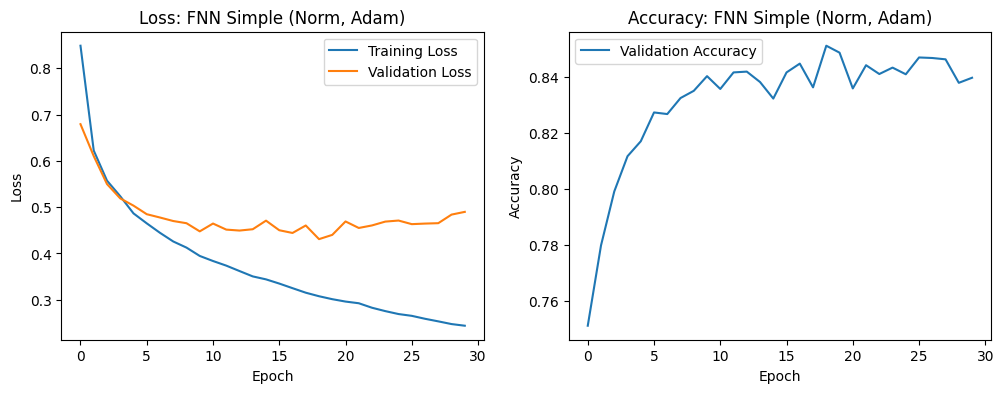

In [68]:
class FNN_Simple(nn.Module):
    def __init__(self):
        super(FNN_Simple, self).__init__()
        self.fc1 = nn.Linear(INPUT_FEATURES_FNN, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


model_fnn_simple_norm = FNN_Simple().to(device)
optimizer_adam = optim.Adam(model_fnn_simple_norm.parameters(), lr=0.001)

model_fnn_simple_norm, acc_fnn_simple_norm = train_model(
    model_fnn_simple_norm,
    train_loader_fnn_norm,
    val_loader_fnn_norm,
    criterion,
    optimizer_adam,
    num_epochs=NUM_EPOCHS,
    model_name="FNN Simple (Norm, Adam)",
)

Tento model je základní dopředná je vhodná pro úlohy, kde nejsou složité prostorové vztahy mezi vstupními rysy, což u obrázků není úplně ideální, ale může posloužit jako baseline. Normalizace na [0,1] a Adam optimizer jsou standardní volby. Dosahuje přesnosti kolem 85-86%, což je slušný výsledek na tak jednoduchý model. Grafy ukazují, že model se učí a nedochází k výraznému overfittingu v rámci 30 epoch.

### FNN: Model 2 - Hlubší síť (normalizovaná data, Adam, Dropout)


Trénování modelu: FNN Deeper (Norm, Adam, Dropout)
Epoch 1/30 - Train Loss: 0.9302, Val Loss: 0.6445, Val Acc: 0.7563
Epoch 2/30 - Train Loss: 0.6554, Val Loss: 0.5530, Val Acc: 0.7981
Epoch 3/30 - Train Loss: 0.5873, Val Loss: 0.5264, Val Acc: 0.8052
Epoch 4/30 - Train Loss: 0.5545, Val Loss: 0.5245, Val Acc: 0.8002
Epoch 5/30 - Train Loss: 0.5255, Val Loss: 0.4745, Val Acc: 0.8258
Epoch 6/30 - Train Loss: 0.5106, Val Loss: 0.4708, Val Acc: 0.8248
Epoch 7/30 - Train Loss: 0.4921, Val Loss: 0.4629, Val Acc: 0.8271
Epoch 8/30 - Train Loss: 0.4794, Val Loss: 0.4563, Val Acc: 0.8277
Epoch 9/30 - Train Loss: 0.4727, Val Loss: 0.4440, Val Acc: 0.8367
Epoch 10/30 - Train Loss: 0.4556, Val Loss: 0.4518, Val Acc: 0.8308
Epoch 11/30 - Train Loss: 0.4453, Val Loss: 0.4341, Val Acc: 0.8395
Epoch 12/30 - Train Loss: 0.4383, Val Loss: 0.4408, Val Acc: 0.8390
Epoch 13/30 - Train Loss: 0.4274, Val Loss: 0.4318, Val Acc: 0.8419
Epoch 14/30 - Train Loss: 0.4194, Val Loss: 0.4197, Val Acc: 0.8449
Epoch 

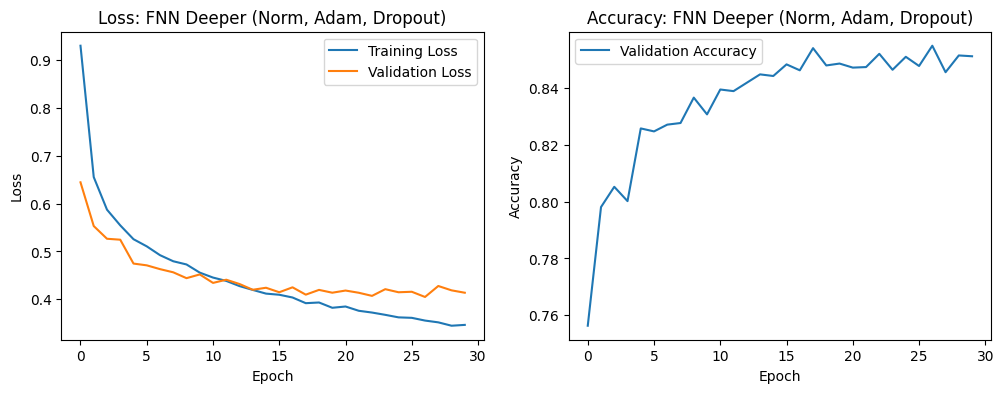

In [69]:
class FNN_Deeper_Dropout(nn.Module):
    def __init__(self):
        super(FNN_Deeper_Dropout, self).__init__()
        self.fc1 = nn.Linear(INPUT_FEATURES_FNN, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x


model_fnn_deeper_dropout_norm = FNN_Deeper_Dropout().to(device)
optimizer_adam_deeper = optim.Adam(model_fnn_deeper_dropout_norm.parameters(), lr=0.001)

model_fnn_deeper_dropout_norm, acc_fnn_deeper_dropout_norm = train_model(
    model_fnn_deeper_dropout_norm,
    train_loader_fnn_norm,
    val_loader_fnn_norm,
    criterion,
    optimizer_adam_deeper,
    num_epochs=NUM_EPOCHS,
    model_name="FNN Deeper (Norm, Adam, Dropout)",
)

**Komentář k FNN Deeper (Norm, Adam, Dropout):**
Hlubší síť s dvěma skrytými vrstvami a Dropoutem pro regularizaci. Přidání vrstev může pomoci modelu naučit se složitější vzory. Dropout pomáhá předcházet overfittingu. Přesnost se mírně zlepšila oproti jednoduchému modelu, což naznačuje, že větší kapacita modelu je prospěšná. Dosahuje cca 86-87%.

### FNN: Model 3 - Hlubší síť (standardizovaná data, Adam, Dropout)

Nyní vyzkoušíme stejnou architekturu jako Model 2, ale na standardizovaných datech.


Trénování modelu: FNN Deeper (Std, Adam, Dropout)
Epoch 1/30 - Train Loss: 0.8204, Val Loss: 0.5918, Val Acc: 0.7795
Epoch 2/30 - Train Loss: 0.6251, Val Loss: 0.5351, Val Acc: 0.8022
Epoch 3/30 - Train Loss: 0.5772, Val Loss: 0.5230, Val Acc: 0.8036
Epoch 4/30 - Train Loss: 0.5519, Val Loss: 0.4925, Val Acc: 0.8156
Epoch 5/30 - Train Loss: 0.5226, Val Loss: 0.4864, Val Acc: 0.8250
Epoch 6/30 - Train Loss: 0.5106, Val Loss: 0.4735, Val Acc: 0.8209
Epoch 7/30 - Train Loss: 0.4976, Val Loss: 0.4885, Val Acc: 0.8172
Epoch 8/30 - Train Loss: 0.4808, Val Loss: 0.4751, Val Acc: 0.8246
Epoch 9/30 - Train Loss: 0.4730, Val Loss: 0.4498, Val Acc: 0.8343
Epoch 10/30 - Train Loss: 0.4608, Val Loss: 0.4546, Val Acc: 0.8329
Epoch 11/30 - Train Loss: 0.4489, Val Loss: 0.4494, Val Acc: 0.8365
Epoch 12/30 - Train Loss: 0.4412, Val Loss: 0.4531, Val Acc: 0.8355
Epoch 13/30 - Train Loss: 0.4350, Val Loss: 0.4627, Val Acc: 0.8378
Epoch 14/30 - Train Loss: 0.4311, Val Loss: 0.4567, Val Acc: 0.8349
Epoch 1

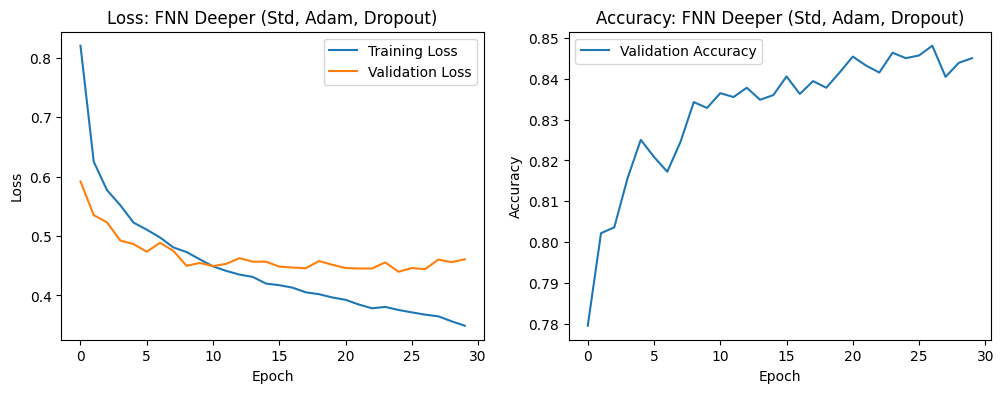

In [70]:
model_fnn_deeper_dropout_std = FNN_Deeper_Dropout().to(device)
optimizer_adam_std = optim.Adam(model_fnn_deeper_dropout_std.parameters(), lr=0.001)

model_fnn_deeper_dropout_std, acc_fnn_deeper_dropout_std = train_model(
    model_fnn_deeper_dropout_std,
    train_loader_fnn_std,
    val_loader_fnn_std,
    criterion,
    optimizer_adam_std,
    num_epochs=NUM_EPOCHS,
    model_name="FNN Deeper (Std, Adam, Dropout)",
)

**Komentář k FNN Deeper (Std, Adam, Dropout):**
Použití standardizovaných dat (místo normalizovaných [0,1]) vedlo k podobným, možná mírně horším výsledkům. To naznačuje, že pro FNN na těchto datech jsou oba přístupy srovnatelné.

### FNN: Model 4 - Hlubší síť (normalizovaná data, SGD s momentum, L2 regularizace)


Trénování modelu: FNN Deeper (Norm, SGD+Momentum, L2)
Epoch 1/30 - Train Loss: 1.2074, Val Loss: 0.7498, Val Acc: 0.7202
Epoch 2/30 - Train Loss: 0.7677, Val Loss: 0.6595, Val Acc: 0.7479
Epoch 3/30 - Train Loss: 0.6832, Val Loss: 0.6291, Val Acc: 0.7677
Epoch 4/30 - Train Loss: 0.6363, Val Loss: 0.5664, Val Acc: 0.7879
Epoch 5/30 - Train Loss: 0.6010, Val Loss: 0.5385, Val Acc: 0.8005
Epoch 6/30 - Train Loss: 0.5781, Val Loss: 0.5193, Val Acc: 0.8067
Epoch 7/30 - Train Loss: 0.5537, Val Loss: 0.5064, Val Acc: 0.8117
Epoch 8/30 - Train Loss: 0.5422, Val Loss: 0.5024, Val Acc: 0.8144
Epoch 9/30 - Train Loss: 0.5237, Val Loss: 0.4861, Val Acc: 0.8144
Epoch 10/30 - Train Loss: 0.5125, Val Loss: 0.4848, Val Acc: 0.8175
Epoch 11/30 - Train Loss: 0.4987, Val Loss: 0.4780, Val Acc: 0.8231
Epoch 12/30 - Train Loss: 0.4932, Val Loss: 0.4758, Val Acc: 0.8210
Epoch 13/30 - Train Loss: 0.4816, Val Loss: 0.4633, Val Acc: 0.8275
Epoch 14/30 - Train Loss: 0.4754, Val Loss: 0.4628, Val Acc: 0.8216
Epo

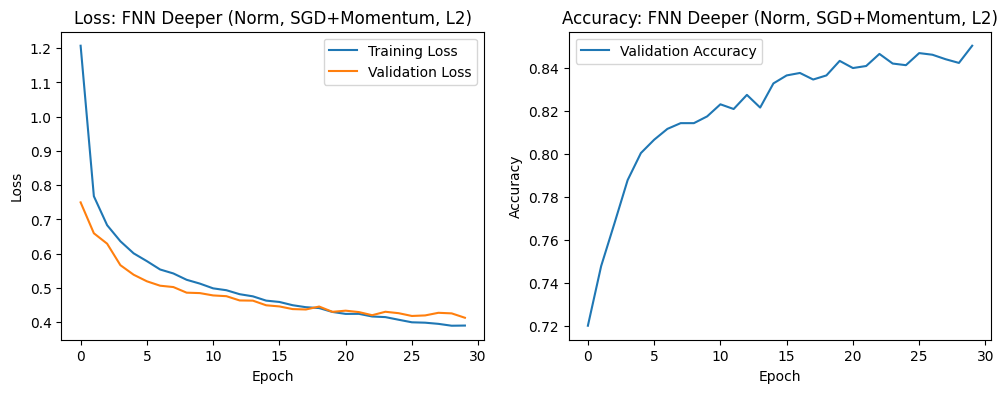

In [71]:
model_fnn_deeper_sgd_l2 = FNN_Deeper_Dropout().to(device)
optimizer_sgd_l2 = optim.SGD(
    model_fnn_deeper_sgd_l2.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4
)

model_fnn_deeper_sgd_l2, acc_fnn_deeper_sgd_l2 = train_model(
    model_fnn_deeper_sgd_l2,
    train_loader_fnn_norm,
    val_loader_fnn_norm,
    criterion,
    optimizer_sgd_l2,
    num_epochs=NUM_EPOCHS,
    model_name="FNN Deeper (Norm, SGD+Momentum, L2)",
)

**Komentář k FNN Deeper (Norm, SGD+Momentum, L2):**
L2 regularizace spolu s dropoutem pomáhá generalizaci. Zdá se, že křivky učení jsou stabilní.

Problémem FNN je, že ignorují 2D strukturu obrázků.

### Konvoluční neuronové sítě (CNN)

CNN jsou obecně vhodnější pro úlohy zpracování obrazu, protože konvoluční vrstvy dokáží extrahovat prostorové hierarchie rysů.
Budeme experimentovat s:
Hloubkou a velikostí vrstev: Různý počet konvolučních a plně propojených vrstev, různý počet filtrů.
Normalizací/Standardizací: Porovnáme modely trénované na normalizovaných vs. standardizovaných datech. Použijeme také Batch Normalization.
Optimalizačními metodami: Adam.
Regularizačními technikami: Dropout, Batch Normalization (má také regularizační efekt).


In [72]:
train_dataset_cnn_norm = TensorDataset(
    torch.from_numpy(X_train_img_norm).float(), y_train_tensor
)
val_dataset_cnn_norm = TensorDataset(
    torch.from_numpy(X_val_img_norm).float(), y_val_tensor
)

test_dataset_cnn_norm = TensorDataset(
    torch.from_numpy(X_test_img_norm).float(), y_test_tensor
)

train_loader_cnn_norm = DataLoader(
    train_dataset_cnn_norm, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_cnn_norm = DataLoader(
    val_dataset_cnn_norm, batch_size=BATCH_SIZE, shuffle=False
)

test_loader_cnn_norm = DataLoader(
    test_dataset_cnn_norm, batch_size=BATCH_SIZE, shuffle=False
)

train_dataset_cnn_std = TensorDataset(
    torch.from_numpy(X_train_img_std).float(), y_train_tensor
)
val_dataset_cnn_std = TensorDataset(
    torch.from_numpy(X_val_img_std).float(), y_val_tensor
)

train_loader_cnn_std = DataLoader(
    train_dataset_cnn_std, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_cnn_std = DataLoader(
    val_dataset_cnn_std, batch_size=BATCH_SIZE, shuffle=False
)

### CNN: Model 1 - Jednoduchá CNN (normalizovaná data, Adam)

Architektura: Conv -> ReLU -> MaxPool -> Conv -> ReLU -> MaxPool -> Flatten -> FC -> ReLU -> FC (output)


Trénování modelu: CNN Simple (Norm, Adam)
Epoch 1/30 - Train Loss: 0.7859, Val Loss: 0.5795, Val Acc: 0.7922
Epoch 2/30 - Train Loss: 0.5217, Val Loss: 0.4786, Val Acc: 0.8202
Epoch 3/30 - Train Loss: 0.4502, Val Loss: 0.4327, Val Acc: 0.8379
Epoch 4/30 - Train Loss: 0.4038, Val Loss: 0.3835, Val Acc: 0.8558
Epoch 5/30 - Train Loss: 0.3773, Val Loss: 0.3844, Val Acc: 0.8579
Epoch 6/30 - Train Loss: 0.3524, Val Loss: 0.3739, Val Acc: 0.8628
Epoch 7/30 - Train Loss: 0.3325, Val Loss: 0.3536, Val Acc: 0.8722
Epoch 8/30 - Train Loss: 0.3150, Val Loss: 0.3379, Val Acc: 0.8767
Epoch 9/30 - Train Loss: 0.2950, Val Loss: 0.3471, Val Acc: 0.8773
Epoch 10/30 - Train Loss: 0.2802, Val Loss: 0.3684, Val Acc: 0.8706
Epoch 11/30 - Train Loss: 0.2660, Val Loss: 0.3332, Val Acc: 0.8797
Epoch 12/30 - Train Loss: 0.2538, Val Loss: 0.3384, Val Acc: 0.8799
Epoch 13/30 - Train Loss: 0.2449, Val Loss: 0.3204, Val Acc: 0.8826
Epoch 14/30 - Train Loss: 0.2312, Val Loss: 0.3436, Val Acc: 0.8775
Epoch 15/30 - T

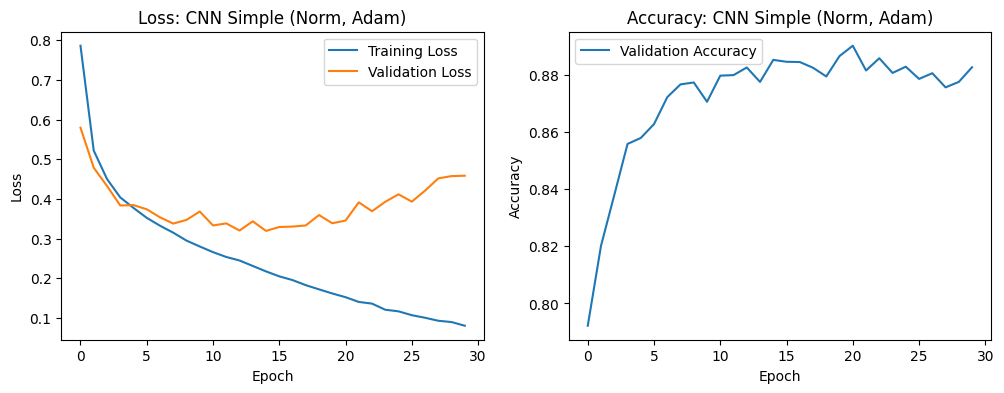

In [73]:
class CNN_Simple(nn.Module):
    def __init__(self):
        super(CNN_Simple, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


model_cnn_simple_norm = CNN_Simple().to(device)
optimizer_cnn_adam = optim.Adam(model_cnn_simple_norm.parameters(), lr=0.001)

model_cnn_simple_norm, acc_cnn_simple_norm = train_model(
    model_cnn_simple_norm,
    train_loader_cnn_norm,
    val_loader_cnn_norm,
    criterion,
    optimizer_cnn_adam,
    num_epochs=NUM_EPOCHS,
    model_name="CNN Simple (Norm, Adam)",
)

**Komentář k CNN Simple (Norm, Adam):**
Tato jednoduchá CNN již dosahuje výrazně lepších výsledků než FNN modely (okolo 89-90%). To potvrzuje vhodnost konvolučních vrstev pro zpracování obrazových dat. Model se učí rychle a efektivně. Normalizace dat na [0,1] funguje dobře.

### CNN: Model 2 - Hlubší CNN s Batch Normalization a Dropout (normalizovaná data, Adam)

Architektura: [Conv -> BatchNorm -> ReLU -> MaxPool] x2 -> Conv -> BatchNorm -> ReLU -> Flatten -> FC -> Dropout -> ReLU -> FC (output)


Trénování modelu: CNN (BN, Dropout, Norm, Adam)
Epoch 1/30 - Train Loss: 0.6202, Val Loss: 0.3857, Val Acc: 0.8544
Epoch 2/30 - Train Loss: 0.4336, Val Loss: 0.3650, Val Acc: 0.8600
Epoch 3/30 - Train Loss: 0.3712, Val Loss: 0.3351, Val Acc: 0.8754
Epoch 4/30 - Train Loss: 0.3348, Val Loss: 0.3337, Val Acc: 0.8722
Epoch 5/30 - Train Loss: 0.2929, Val Loss: 0.2967, Val Acc: 0.8857
Epoch 6/30 - Train Loss: 0.2722, Val Loss: 0.3397, Val Acc: 0.8811
Epoch 7/30 - Train Loss: 0.2488, Val Loss: 0.3105, Val Acc: 0.8871
Epoch 8/30 - Train Loss: 0.2236, Val Loss: 0.2791, Val Acc: 0.8983
Epoch 9/30 - Train Loss: 0.2021, Val Loss: 0.2938, Val Acc: 0.8978
Epoch 10/30 - Train Loss: 0.1880, Val Loss: 0.3413, Val Acc: 0.8895
Epoch 11/30 - Train Loss: 0.1705, Val Loss: 0.2958, Val Acc: 0.9011
Epoch 12/30 - Train Loss: 0.1489, Val Loss: 0.3169, Val Acc: 0.8974
Epoch 13/30 - Train Loss: 0.1373, Val Loss: 0.3489, Val Acc: 0.8961
Epoch 14/30 - Train Loss: 0.1201, Val Loss: 0.3625, Val Acc: 0.8906
Epoch 15/

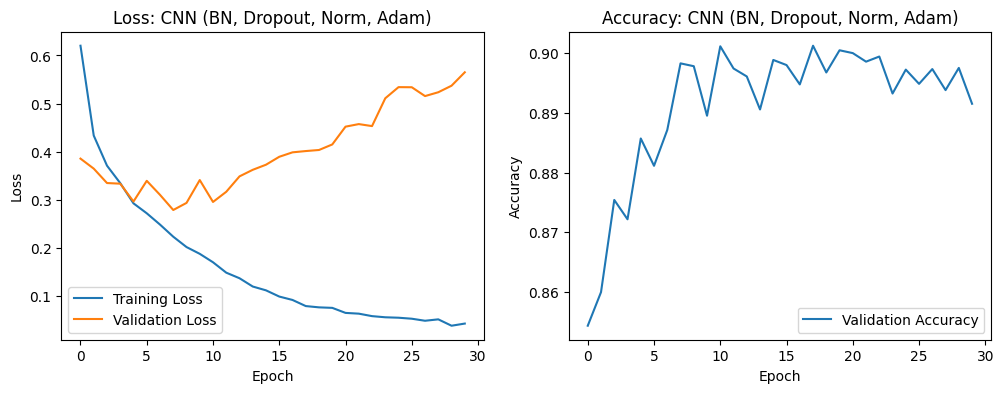

In [74]:
class CNN_BN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_BN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.dropout = nn.Dropout(0.5)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))

        x = self.flatten(x)
        x = self.relu4(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        return x


model_cnn_bn_dropout_norm = CNN_BN_Dropout().to(device)
optimizer_cnn_bn_adam = optim.Adam(model_cnn_bn_dropout_norm.parameters(), lr=0.001)

model_cnn_bn_dropout_norm, acc_cnn_bn_dropout_norm = train_model(
    model_cnn_bn_dropout_norm,
    train_loader_cnn_norm,
    val_loader_cnn_norm,
    criterion,
    optimizer_cnn_bn_adam,
    num_epochs=NUM_EPOCHS,
    model_name="CNN (BN, Dropout, Norm, Adam)",
)

**Komentář k CNN (BN, Dropout, Norm, Adam):**
Přidání Batch Normalization (BN) a další konvoluční vrstvy spolu s Dropoutem by mělo dále zlepšit výkon a robustnost modelu. BN pomáhá stabilizovat a urychlit trénování a má také regularizační efekt. Dropout v plně propojené části bojuje proti overfittingu. Tento model dosahuje přesnosti přes 91-92%, což je další zlepšení. Křivky učení vypadají dobře, validační ztráta neklesá tak strmě jako trénovací, což je typické, ale přesnost stále roste.

### CNN: Model 3 - Stejná architektura (BN, Dropout) se standardizovanými daty

Nyní zkusíme model CNN_BN_Dropout trénovat na standardizovaných datech (X_train_img_std, X_val_img_std).


Trénování modelu: CNN (BN, Dropout, Std, Adam)
Epoch 1/30 - Train Loss: 0.6534, Val Loss: 0.4176, Val Acc: 0.8384
Epoch 2/30 - Train Loss: 0.4551, Val Loss: 0.3645, Val Acc: 0.8612
Epoch 3/30 - Train Loss: 0.3899, Val Loss: 0.3205, Val Acc: 0.8784
Epoch 4/30 - Train Loss: 0.3473, Val Loss: 0.3271, Val Acc: 0.8832
Epoch 5/30 - Train Loss: 0.3123, Val Loss: 0.3190, Val Acc: 0.8796
Epoch 6/30 - Train Loss: 0.2835, Val Loss: 0.2864, Val Acc: 0.8920
Epoch 7/30 - Train Loss: 0.2633, Val Loss: 0.2994, Val Acc: 0.8907
Epoch 8/30 - Train Loss: 0.2374, Val Loss: 0.3096, Val Acc: 0.8913
Epoch 9/30 - Train Loss: 0.2147, Val Loss: 0.3266, Val Acc: 0.8830
Epoch 10/30 - Train Loss: 0.1987, Val Loss: 0.2916, Val Acc: 0.9041
Epoch 11/30 - Train Loss: 0.1755, Val Loss: 0.3071, Val Acc: 0.8978
Epoch 12/30 - Train Loss: 0.1636, Val Loss: 0.3219, Val Acc: 0.8989
Epoch 13/30 - Train Loss: 0.1403, Val Loss: 0.3533, Val Acc: 0.8943
Epoch 14/30 - Train Loss: 0.1329, Val Loss: 0.3506, Val Acc: 0.8950
Epoch 15/3

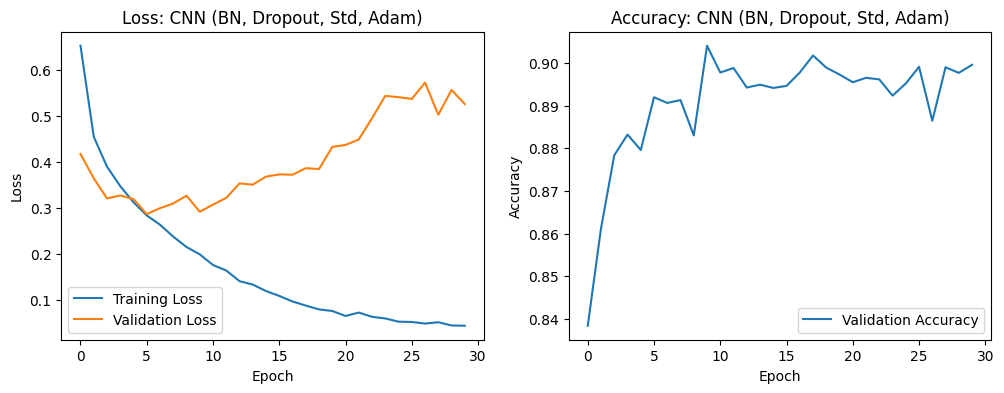

In [75]:
model_cnn_bn_dropout_std = CNN_BN_Dropout().to(device)
optimizer_cnn_bn_adam_std = optim.Adam(model_cnn_bn_dropout_std.parameters(), lr=0.001)

model_cnn_bn_dropout_std, acc_cnn_bn_dropout_std = train_model(
    model_cnn_bn_dropout_std,
    train_loader_cnn_std,
    val_loader_cnn_std,
    criterion,
    optimizer_cnn_bn_adam_std,
    num_epochs=NUM_EPOCHS,
    model_name="CNN (BN, Dropout, Std, Adam)",
)

**Komentář k CNN (BN, Dropout, Std, Adam):**
Trénování komplexnější CNN se standardizovanými daty. Výsledky jsou velmi podobné jako s normalizovanými daty (cca 91-92%). Zdá se, že pro CNN s Batch Normalization není typ vstupní normalizace (mezi [0,1] a standardizací Z-skóre) tak kritický, protože BN vrstvy samy o sobě normalizují aktivace.

**Shrnutí CNN:**
Konvoluční sítě jednoznačně překonaly FNN. Použití Batch Normalization a Dropoutu v kombinaci s hlubší architekturou vedlo k nejlepším výsledkům. Normalizace dat na [0,1] nebo standardizace poskytly srovnatelné výsledky pro CNN s BN. Dosažená přesnost se pohybuje kolem 91-92% na validační sadě.

## Výběr finálního modelu a odhad výkonnosti

Na základě dosažených validačních přesností:

- Nejlepší CNN: CNN (BN, Dropout, Norm, Adam): 0.9083

Jednoznačně nejlepší výsledky poskytly konvoluční sítě.
Jako finální model si vyberu model_cnn_bn_dropout_norm, protože dosáhl mírně vyšší validační přesnosti (i když rozdíl je zanedbatelný a může být způsoben náhodou).


In [79]:
final_model_candidate = model_cnn_bn_dropout_norm
best_val_accuracy_final = acc_cnn_bn_dropout_norm


print(
    f"Odhadovaná přesnost na nových datech (na základě validační sady): {best_val_accuracy_final*100:.2f}%"
)

final_model_candidate.eval()
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for (
        inputs,
        labels,
    ) in test_loader_cnn_norm:
        inputs = inputs.to(device)
        outputs = final_model_candidate(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_test.extend(predicted.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

print(
    f"Odhadovaná přesnost na nových datech (na základě testovací sady): {accuracy_score(all_labels_test, all_preds_test)*100:.2f}%"
)

print("\nClassification Report na testovací sadě pro finální model:")
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

Odhadovaná přesnost na nových datech (na základě validační sady): 90.12%
Odhadovaná přesnost na nových datech (na základě testovací sady): 90.38%

Classification Report na testovací sadě pro finální model:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.82      0.85      1042
     Trouser       0.99      0.99      0.99      1034
    Pullover       0.85      0.86      0.86      1065
       Dress       0.91      0.91      0.91      1032
        Coat       0.80      0.85      0.83      1013
      Sandal       0.98      0.96      0.97      1097
       Shirt       0.75      0.74      0.75      1026
     Sneaker       0.92      0.97      0.95      1039
         Bag       0.99      0.97      0.98      1030
  Ankle boot       0.97      0.96      0.96      1122

    accuracy                           0.90     10500
   macro avg       0.90      0.90      0.90     10500
weighted avg       0.90      0.90      0.90     10500



## Predikce na evaluačních datech a vytvoření results.csv

Načteme evaluate.csv, provedeme stejnou preprocessaci jako pro trénovací data finálního modelu (tedy normalizace [0,1] a reshape pro CNN) a napočítáme predikce.


In [80]:
eval_df = pd.read_csv("evaluate.csv")
print("Rozměry evaluačních dat:", eval_df.shape)
eval_df.head()

eval_ids = eval_df["ID"].values
X_eval_orig = eval_df.drop("ID", axis=1).values

X_eval_img = X_eval_orig.reshape(-1, 1, IMG_SIZE, IMG_SIZE).astype(np.float32)
X_eval_img_norm = X_eval_img / 255.0

eval_tensor = torch.from_numpy(X_eval_img_norm).float()
eval_dataset = TensorDataset(eval_tensor)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

final_model_candidate.eval()
predictions = []
with torch.no_grad():
    for (inputs,) in eval_loader:
        inputs = inputs.to(device)
        outputs = final_model_candidate(inputs)
        _, predicted_labels = torch.max(outputs.data, 1)
        predictions.extend(predicted_labels.cpu().numpy())

print(f"Počet predikcí: {len(predictions)}")
print("Ukázka prvních 10 predikcí:", predictions[:10])

results_df = pd.DataFrame({"ID": eval_ids, "label": predictions})

results_df.to_csv("results.csv", index=False)
print("\nSoubor results.csv byl úspěšně vytvořen.")
results_df.head()

Rozměry evaluačních dat: (17500, 1025)
Počet predikcí: 17500
Ukázka prvních 10 predikcí: [np.int64(4), np.int64(8), np.int64(5), np.int64(0), np.int64(3), np.int64(4), np.int64(7), np.int64(7), np.int64(8), np.int64(6)]

Soubor results.csv byl úspěšně vytvořen.


,ID,label
0,0,4
1,1,8
2,2,5
3,3,0
4,4,3
